# Gaussian Process Regression: 2D Sine+Cosine Function

In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

## Generate data and ground truth surface

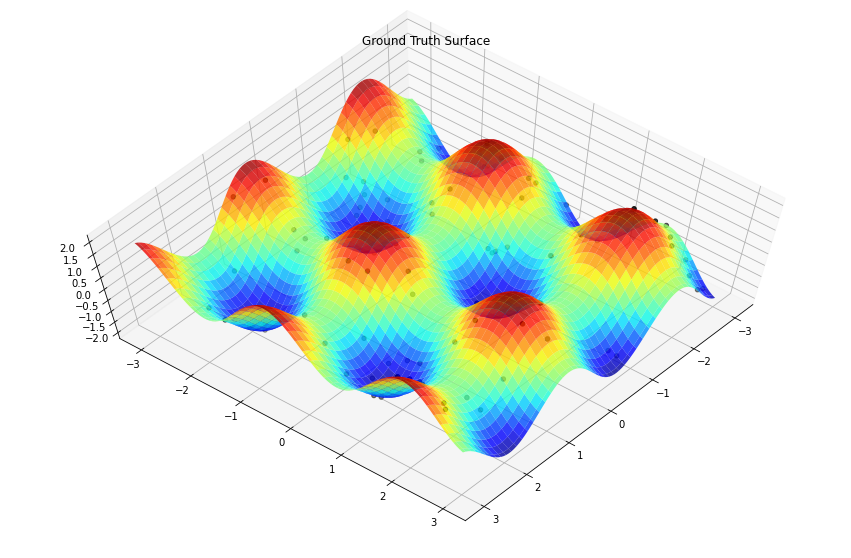

In [2]:
np.random.seed(42)

# Ground truth function to be discovered
f = lambda x: np.sin(x[0]*2.5) + np.cos(x[1]*2.5 + np.pi/2)

# Generate data set
N = 100
X = np.random.rand(N,2)*6 - 3
y = np.zeros(N)
for i in range(N):
    y[i] = f(X[i,:])

# Visualize the ground truth function
xv, yv = np.meshgrid(np.linspace(-3,3,100),
                     np.linspace(-3,3,100))
y_true = np.zeros((len(xv),len(yv)))
for i in range(len(xv)):
    for j in range(len(yv)): 
        y_true[i,j] = f(np.array([xv[i,j], yv[i,j]]))
        
def plotSurface(X, y, xv, yv, y_surf, fig, sub_plot):
    if sub_plot == 0:
        ax = plt.axes(projection='3d')
        ax.scatter3D(X[:,0], X[:,1], y, s=20, c='k')
    elif sub_plot == 1: 
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.scatter3D(X[:,0], X[:,1], y, s=20, c='k')
    else:
        ax = fig.add_subplot(1, 2, 2, projection='3d')
    
    surf = ax.plot_surface(xv, yv, y_surf,
                           linewidth = 0,
                           cmap=cm.jet,
                           alpha=0.8)
    #fig.colorbar(surf, shrink=0.5)
    ax.view_init(elev=70, azim=40)
    return ax

fig = plt.figure(figsize=(15,10))
plotSurface(X, y, xv, yv, y_true, fig, 0)
plt.title('Ground Truth Surface')
plt.show()

## Create GPR class

In [3]:
class GPRegression:
    def __init__(self, X_train, y_train, sigma, gamma):
        self.X_train = X_train
        self.y_train = y_train
        self.N_train = X_train.shape[0]
        self.sigma = sigma
        self.gamma = gamma
        self.K = self.kernel_func(X_train, X_train)
        
    def kernel_func(self, x1, x2):
        return np.exp(-self.gamma * pairwise_distances(x1, x2, metric='sqeuclidean'))

    def predict(self, x):
        # For k(x), a single sample x should be reshaped for pairwise distances to work 
        kx = self.kernel_func(x.reshape(1,-1), self.X_train)
        kxx = self.kernel_func(x.reshape(1,-1), x.reshape(1,-1))
        C = np.linalg.inv(self.K + self.sigma ** 2 * np.eye(self.N_train))
        mu = kx @ C @ self.y_train                  # Eq. (6.66), PRML
        sd = kxx + self.sigma ** 2 - kx @ C @ kx.T  # Eq. (6.67), PRML
        return mu, np.sqrt(sd)

## Perform sequential fitting

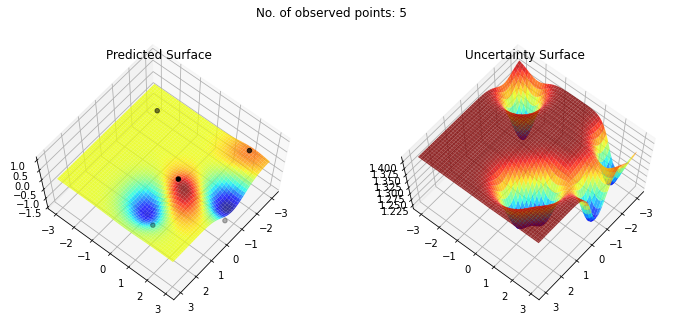

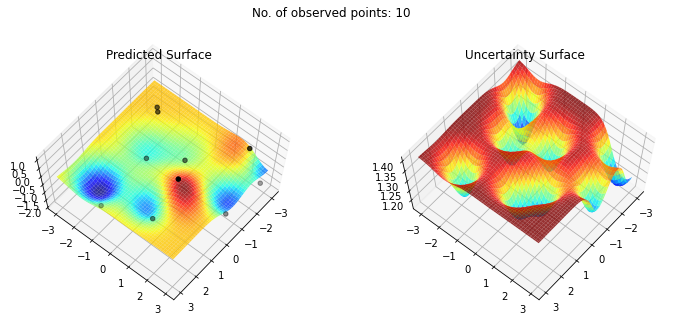

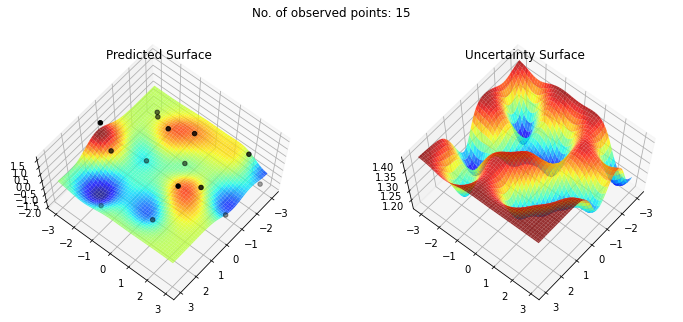

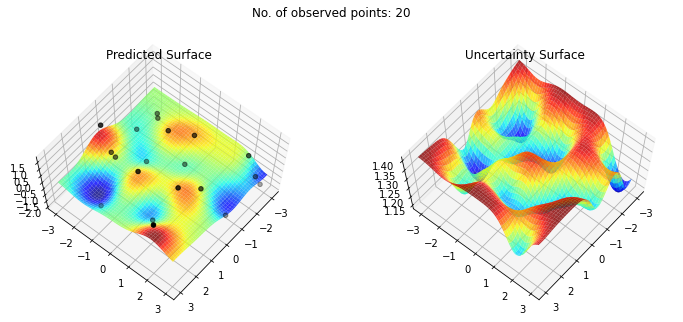

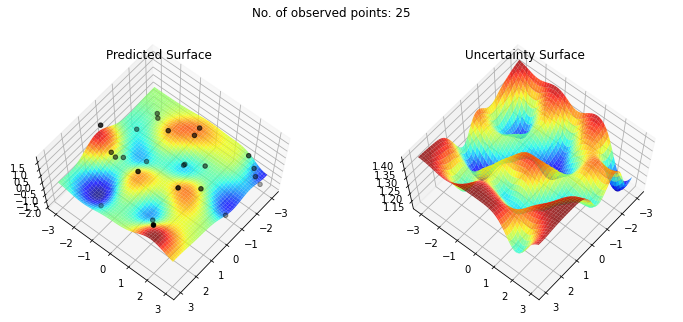

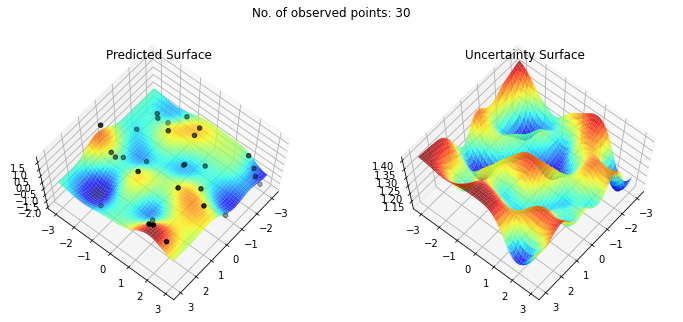

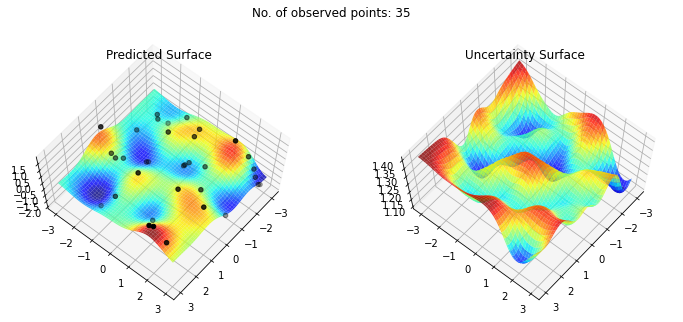

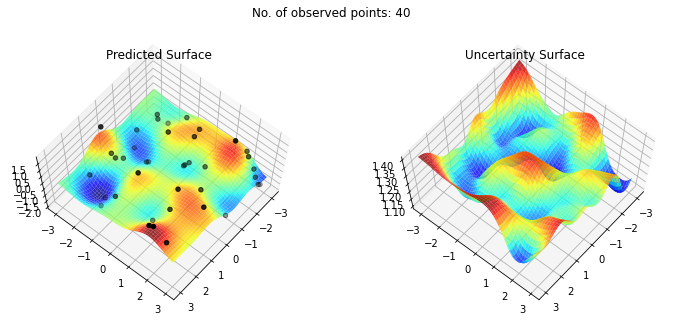

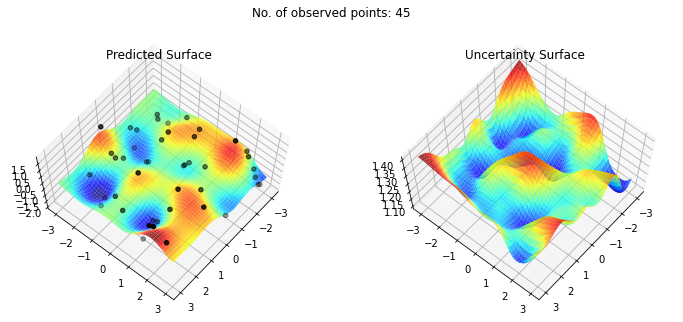

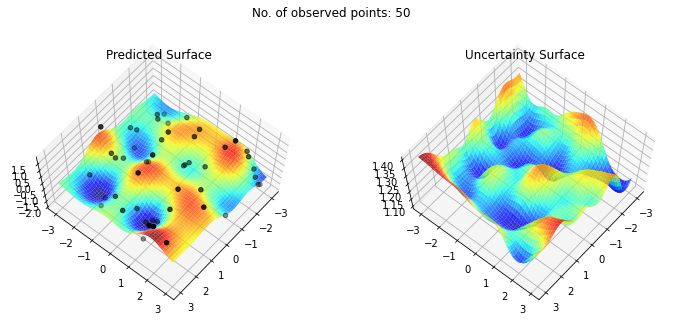

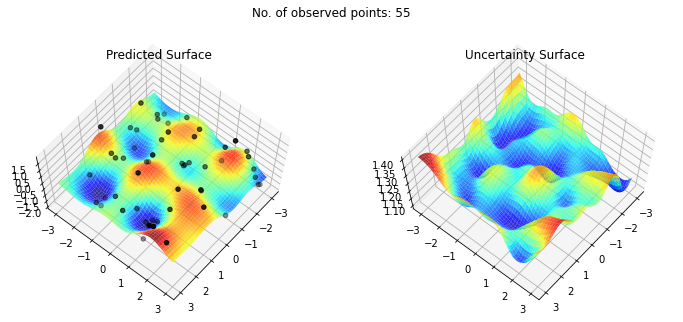

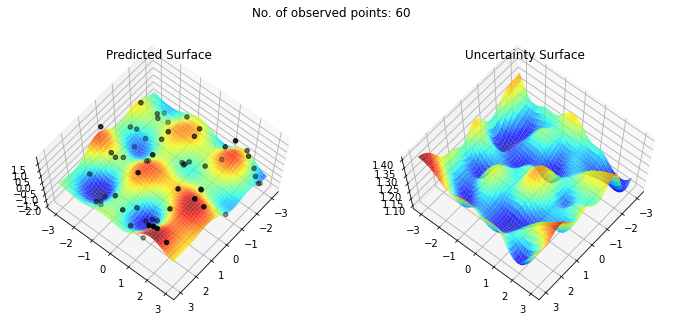

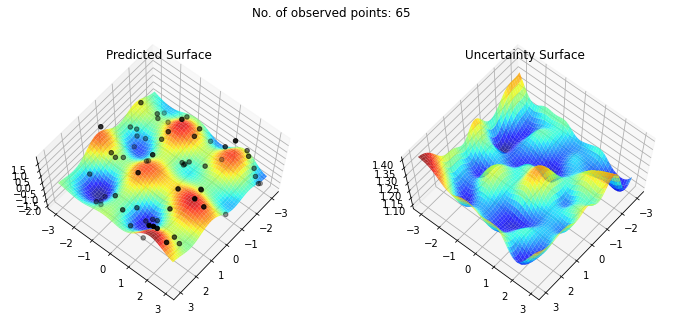

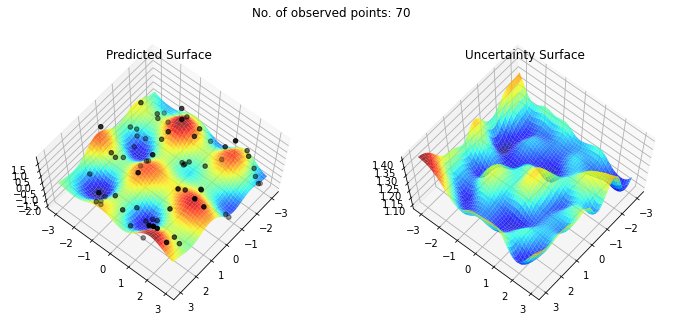

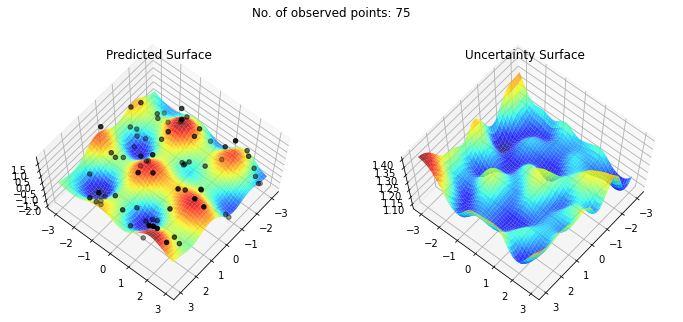

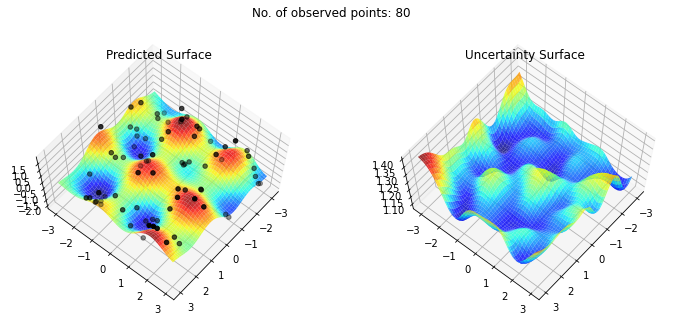

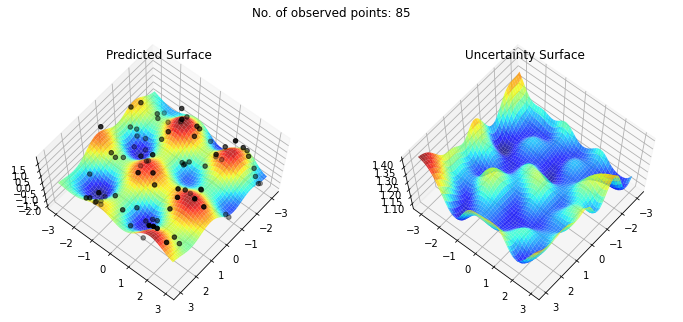

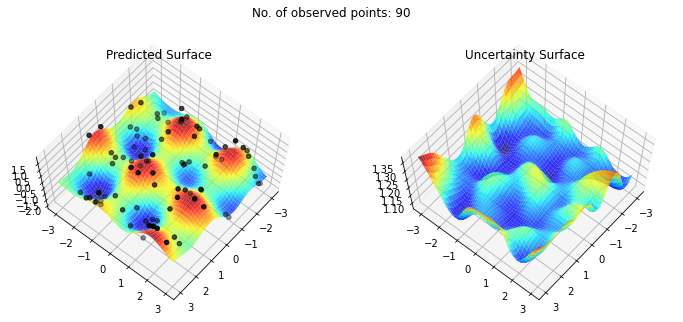

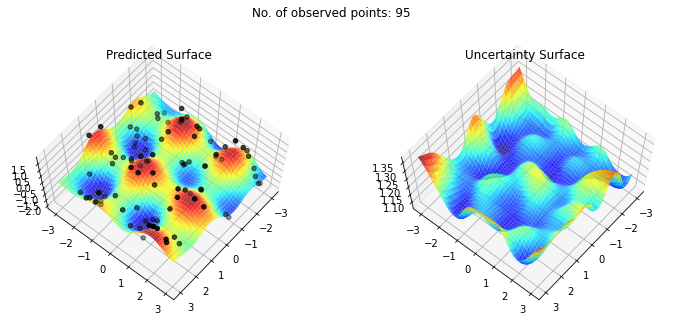

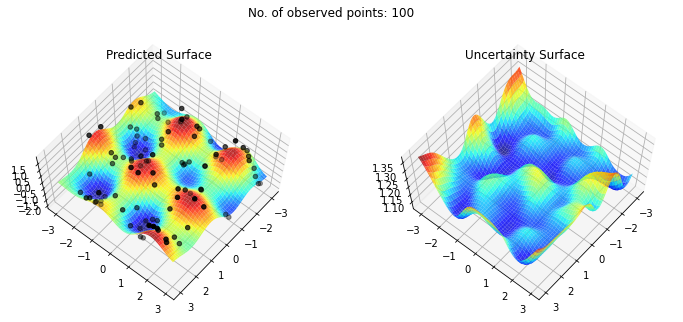

In [4]:
for i in range(5,N+1,5):
    X_train, y_train = X[:i,:], y[:i]
    mdl = GPRegression(X_train, y_train, sigma=1, gamma=1)
    y_pred = np.zeros((len(xv),len(yv)))
    sd_pred = np.zeros(y_pred.shape)
    for i in range(len(xv)):
        for j in range(len(yv)): 
            y_pred[i,j], sd_pred[i,j] = mdl.predict(np.array([xv[i,j], yv[i,j]]))
    
    fig = plt.figure(figsize=(12,5))
    ax = plotSurface(X_train, y_train, xv, yv, y_pred, fig, 1)
    ax.set_title('Predicted Surface')
    ax = plotSurface(X_train, y_train, xv, yv, sd_pred, fig, 2)
    ax.set_title('Uncertainty Surface')
    plt.suptitle(f'No. of observed points: {len(y_train)}')
    plt.show()